## De-Skewing Documents Using Fourier Transform and Hough Transform ( New Approach)

Here, I used a different approach to de-skew documents. 
First, I applied fourier transfrom to the image. In the Fourier domain image, each point represents a particular frequency contained in the spatial domain image.
Then applied,used edge detection to extract edge feature (which is usually like  white strip of light showing the orientation).
Last, I applied hough tansform to detect the line and its orientation.


For References I followed following resources: 

https://homepages.inf.ed.ac.uk/rbf/HIPR2/fourier.htm
https://plus.maths.org/content/fourier-transforms-images
https://www.researchgate.net/publication/221472741_A_New_Algorithm_for_Skew_Detection_in_Images_of_Documents
https://www.researchgate.net/publication/295256106_An_approach_for_Skew_Detection_using_Hough_Transform https://www.researchgate.net/publication/287217803_A_Survey_on_Document_Image_Skew_Detection https://www.researchgate.net/publication/294578383_A_Novel_Skew_Detection_and_Correction_Approach_for_Scanned_Documents http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.hough_line_peaks http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=52D3EF125E41240A6C364B2E32721F2B?doi=10.1.1.105.3741&rep=rep1&type=pdf

This method works for most cases. ( I have yet to fully verify some mathematics behind some functions.)

In [2]:
# important modules
import numpy as np
import cv2

from skimage.transform import (hough_line, hough_line_peaks,probabilistic_hough_line)
from skimage.feature import canny
from skimage import data

import matplotlib.pyplot as plt
from matplotlib import cm

In [3]:
# function later used to find the angle of skweness
def Skewed_angle(x1, y1, x2, y2): 
    try:
        y= (y2-y1) # numerator of arctan
        x= (x2-x1) #denominator of arctan
        return (np.rad2deg(np.arctan2(y,x)))
        
    except ZeroDivisionError:
        return 0

In [4]:
# load the image we want to de-skew
def load_image ( path):
    
    
    try:
        img = cv2.imread(path)
        # perform BRG to gray scale conversion,we need only gray scale information
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 

        #covert the gray scale image to binary image; here, 0 is the min-thresold for binarization (adjustable, but usually small)
        # returns the binarized image vector to "binary"
        binary = cv2.threshold(gray,0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]  
        
        #dilation = cv2.dilate(binary,(5,5),iterations = 2) # dilate the white pixels of image
        #binary = dilation
        return img, binary
    except:
        print ("Could not load the image; provide correct path")
        return None, None

In [5]:
# calculate the the degree of skewness
# estimated lines are plotted to visualize
def estimate_skewness(binary_image):    
    
    # perform fast fourier transform of the image to find frequency information
    f = np.fft.fft2(binary_image)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    
    magnitude_spectrum= magnitude_spectrum.astype(np.uint8) # convert to 8 bit channel, back to like binary image
    magnitude_spectrum = cv2.bitwise_not(magnitude_spectrum) # invert black and white pixels
    
    # perform canny edge detection to extract magnitude_spectrum from image, which is in the form of edge information
    edge = cv2.Canny(magnitude_spectrum,150,200)
    
    # Generate figures to visualize steps in fourier transform and hough line detection
    fig, axes = plt.subplots(2,2, figsize=(30, 30))
    ax = axes.ravel()
    
    #view the input image
    ax[0].imshow(binary_image, cmap=cm.gray)
    ax[0].set_title('Input image')
    ax[0].set_axis_off()
    
    # view the magnitude_spectrum after fourier transform
    ax[1].imshow(magnitude_spectrum, cmap=cm.gray)
    ax[1].set_axis_off()
    ax[1].set_title('Magnitude Spectrum')
    
    #view the edge detection
    ax[2].imshow(edge, cmap=cm.gray)
    ax[2].set_title('Edge Detection')
    ax[2].set_axis_off()
    
    # Classic straight-line Hough transform
    h, theta, d = hough_line(edge)
    
    lines= hough_line_peaks(h, theta, d,10,num_peaks = 1) # detect only one highest voted line
    line_angle=0


    
    if lines[1].size>0:
        for _,angle, dist in zip(*lines):
            y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
            y1 = (dist - magnitude_spectrum.shape[1] * np.cos(angle)) / np.sin(angle)
            line_angle = Skewed_angle (0,y0,binary_image.shape[1],y1)
            ax[3].plot((0, magnitude_spectrum.shape[1]), (y0, y1), '-r')

        ax[3].set_xlim((0, magnitude_spectrum.shape[1]))
        ax[3].set_ylim((magnitude_spectrum.shape[0], 0))
    

    plt.show()
    return line_angle

In [18]:
# de-skew the image 
def de_skew(img, angle):
    rows,cols,_ = img.shape
    
    
    if abs(90+angle) > 90:
        rot_angle = angle-90
    else:
        rot_angle= 90+angle
        
    print ("Angle : ", rot_angle)

    M = cv2.getRotationMatrix2D((cols/2,rows/2), round(rot_angle), 1)
    dst = cv2.warpAffine(img,M,(cols,rows),flags=cv2.INTER_LINEAR)
    fig2= plt.figure (figsize=(15,15))

    plt. imshow (dst[:,:,::-1])
    cv2.imwrite('corrected_image.jpg',dst) # save the image in default directory

### Steps: (Main Program begins here)

1)load image: Run load function with correct path of the image.

2)estimate skewness: Run "estimate_skewness" function using the binarized image returned by load function. But, check before if returned binary is empty or not; sometimes binary may be empty due to incorrect image path.

3)De-skew the image: Run de_skew function to correct the skewness

All the following functions could be incorporated in a single class, later; to add abstraction.
Following steps are implemented in the script below

(0, 1654) (-93745.50097930331, 94731.1303519431)
(2339, 1654)


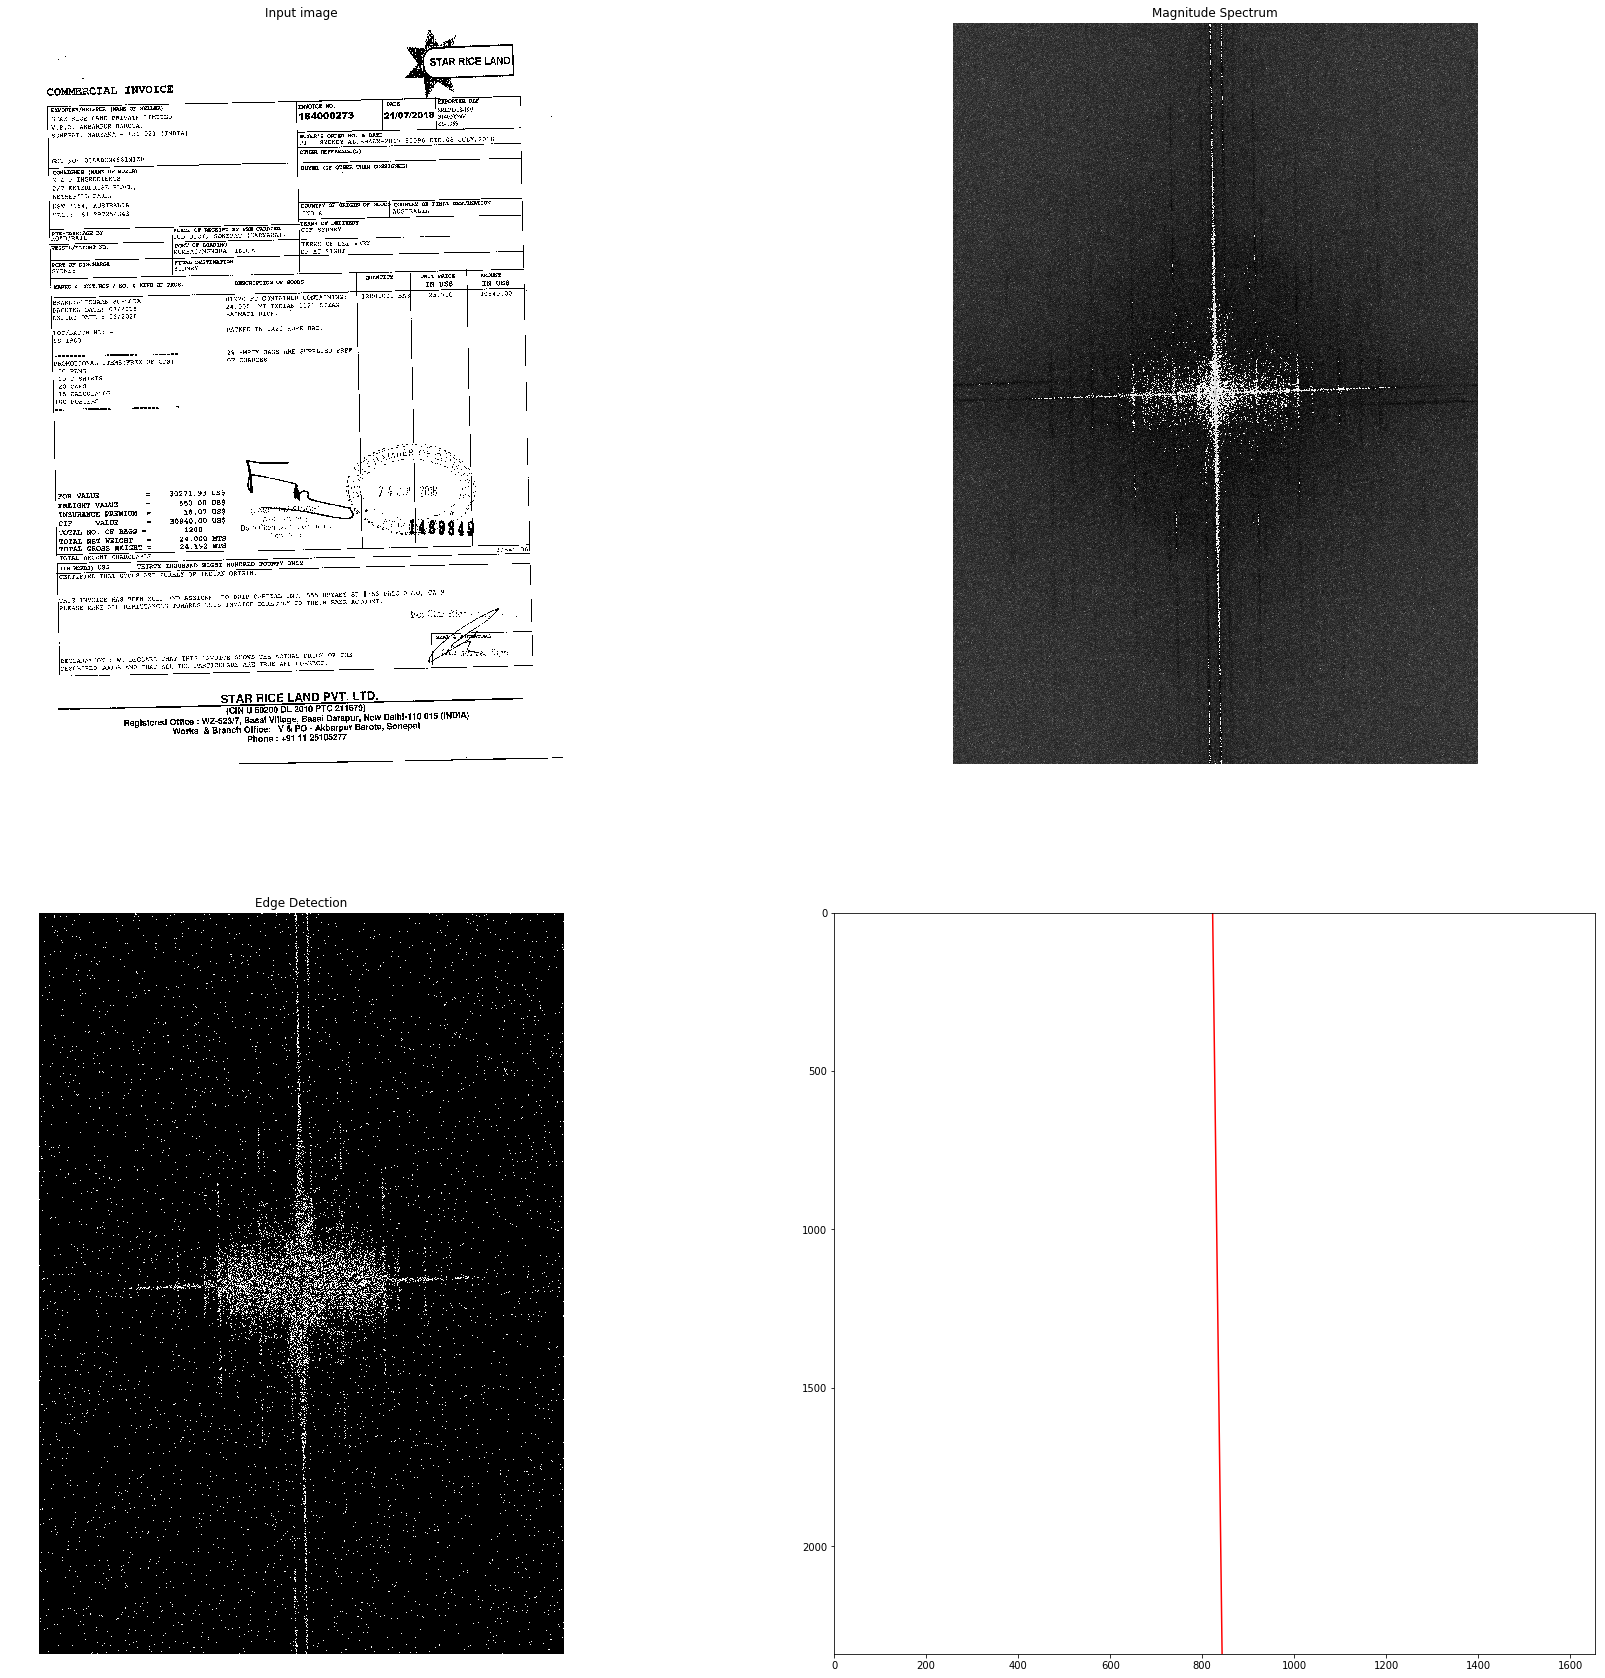

Angle :  -0.5027932960893935


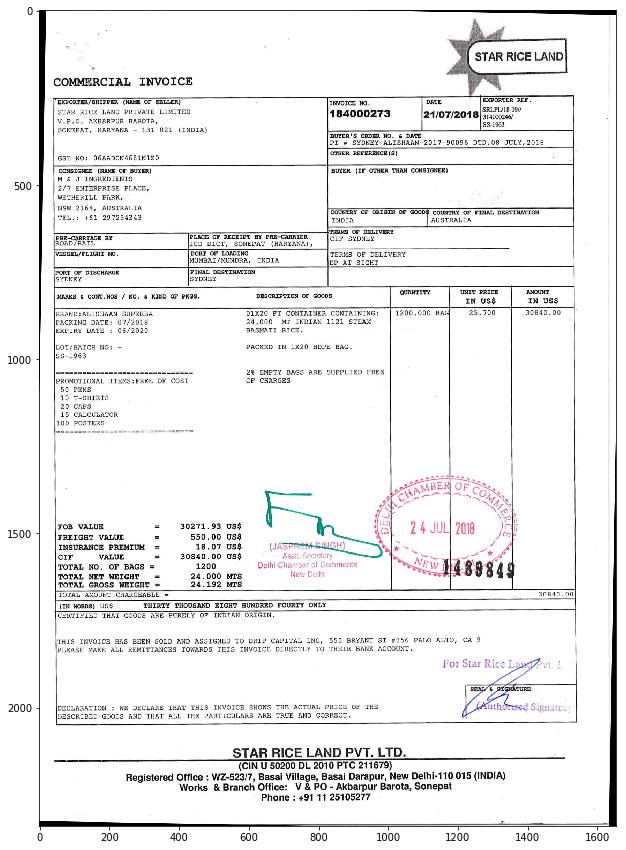

In [37]:
# run the above mentioned steps to execute the code

img, binary = load_image('C:/Users/Brinda Khanal/Downloads/images/images/14.jpg')

#check if binary is None or not; sometimes binary may be empty due to incorrect image path
if binary is not None:
    angle= estimate_skewness(binary)
    de_skew (img,angle)
